In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mkdir ./.kaggle
import json
token = {"username":"e211097","key":"d1cbc0614124c60ed9eca762e87944cb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c aerial-cactus-identification
!unzip ./{/content}/competitions/aerial-cactus-identification/train.zip

# Import libraries and define paths

In [1]:
import numpy as np
import pandas as pd 

import os




from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet169

ORIGIN_PATH=os.getcwd()
path=os.path.abspath("kaggle.json")
train_path = os.path.abspath("train")
# train_path=os.path.join(path,"train")
# test_path=os.path.join(path,"test")
# train_label=os.path.join(path,"train.csv")
# train_label = os.path.abspath("train.csv")

Using TensorFlow backend.


# Loading the labels from csv file

In [2]:
# train_label=os.path.join(path,"train.csv")
data=pd.read_csv("./{/content}/competitions/aerial-cactus-identification/train.csv")
print(data.size)
data.head()

35000


id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1

### Read images and search for the image label. The images data to be added to the dataset and corresponding label to be added to the label array 

In [3]:
from skimage.io import imread
import cv2

train_images = os.listdir(train_path)
# test_images = os.listdir(test_path)
SIZE = 64
dataset = []
label = []
for i, image_id in enumerate(train_images):
    try:

        
        image_path=os.path.join(train_path,image_id)
        image = cv2.imread(image_path)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        label.append(data[data['id'] == image_id]['has_cactus'].values[0]) 
        dataset.append(np.array(image))
        
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

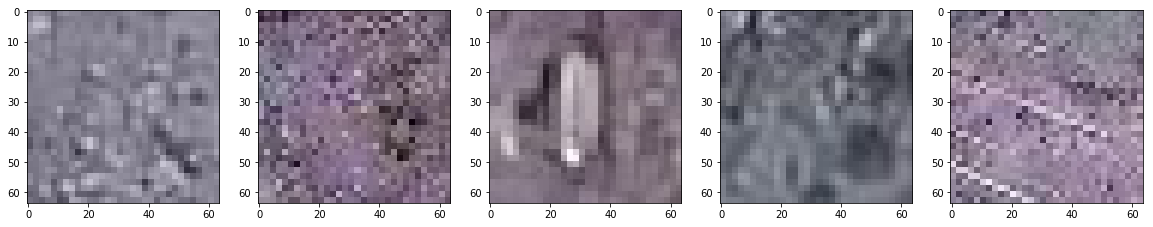

In [4]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(train_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[image_index])

In [5]:
dataset = np.asarray(dataset)
dataset = dataset.astype('float32')

dataset /= 255
label = np.asarray(label)

In [6]:
idx = np.arange(dataset.shape[0])
np.random.shuffle(idx)
dataset = dataset[idx]
label = label[idx]

# CNN model

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD

height = 64
width = 64
classes = 2
channels = 3
chanDim = -1

    
inputShape = (height, width, channels)
chanDim = -1
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.2))

model.add(Flatten())
    
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization(axis = chanDim))
model.add(Dropout(0.2))
model.add(Dense(classes, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxP

## fitting our model 

In [8]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(label), test_size = 0.20, random_state = 0)


h = model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
14000/14000 [==============================] - 106s 8ms/step - loss: 0.2040 - acc: 0.9333
Epoch 2/20
14000/14000 [==============================] - 96s 7ms/step - loss: 0.1051 - acc: 0.9619
Epoch 3/20
14000/14000 [==============================] - 95s 7ms/step - loss: 0.0768 - acc: 0.9725
Epoch 4/20
14000/14000 [==============================] - 97s 7ms/step - loss: 0.0601 - acc: 0.9779
Epoch 5/20
14000/14000 [==============================] - 97s 7ms/step - loss: 0.0467 - acc: 0.9831
Epoch 6/20
14000/14000 [==============================] - 96s 7ms/step - loss: 0.0439 - acc: 0.9841
Epoch 7/20
14000/14000 [==============================] - 100s 7ms/step - loss: 0.0366 - acc: 0.9871
Epoch 8/20
14000/14000 [==============================] - 91s 7ms/step - loss: 0.0297 - acc: 0.9892
Epoch 9/20
14000/14000 [==============================] - 92s 7ms/step - loss: 0.0342 - acc: 0.9877
Epoch 10/20
14000/14000 [=========================

# Evaluate our model 

In [9]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0743982544633826
Test accuracy: 0.9771428571428571


# Pre_bulit model (VGG19) 

In [10]:
from keras.applications import VGG19

VGG19_net = VGG19(weights='imagenet', 
                  include_top=False, 
                  input_shape=(64, 64, 3))
VGG19_net.trainable = False
VGG19_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [11]:
model1 = Sequential()
model1.add(VGG19_net)
model1.add(Flatten())
model1.add(Dense(256))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [12]:
batch_size = 64
nb_epoch = 20
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)
print(y_train)


[1 0 0 ... 1 1 1]


In [13]:

hist = model1.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

Train on 12600 samples, validate on 1400 samples
Epoch 1/20
 - 922s - loss: 0.5775 - acc: 0.7129 - val_loss: 0.4523 - val_acc: 0.7443
Epoch 2/20
 - 773s - loss: 0.4347 - acc: 0.7971 - val_loss: 0.3653 - val_acc: 0.8029
Epoch 3/20
 - 823s - loss: 0.3596 - acc: 0.8420 - val_loss: 0.3075 - val_acc: 0.8836
Epoch 4/20
 - 838s - loss: 0.3095 - acc: 0.8743 - val_loss: 0.2712 - val_acc: 0.9071
Epoch 5/20
 - 838s - loss: 0.2709 - acc: 0.8943 - val_loss: 0.2458 - val_acc: 0.9193
Epoch 6/20
 - 838s - loss: 0.2444 - acc: 0.9117 - val_loss: 0.2261 - val_acc: 0.9271
Epoch 7/20
 - 840s - loss: 0.2238 - acc: 0.9194 - val_loss: 0.2093 - val_acc: 0.9443
Epoch 8/20
 - 841s - loss: 0.2084 - acc: 0.9256 - val_loss: 0.1975 - val_acc: 0.9443
Epoch 9/20
 - 842s - loss: 0.1947 - acc: 0.9371 - val_loss: 0.1893 - val_acc: 0.9421
Epoch 10/20
 - 820s - loss: 0.1837 - acc: 0.9371 - val_loss: 0.1785 - val_acc: 0.9471
Epoch 11/20
 - 777s - loss: 0.1740 - acc: 0.9425 - val_loss: 0.1714 - val_acc: 0.9514
Epoch 12/20
 -

In [14]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11870406399454389
Test accuracy: 0.9597142857824054


### as we can see both models are giving a high accuracy reached to 98% which can be also increase in case of data augmentation or using diifferent CNN structure 